In [1]:
import torch
from nets import ConvDecoder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch import nn
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/inside_rot_rgb8_1_10k_norm_np.pkl", 'rb') as f:
    data = pickle.load(f)

pose, img = data

In [3]:
# data preperation
batch_size = 100
train_test_ratio = 0.7

ratio_id = int(pose.shape[0] * train_test_ratio)

train_pose = pose[:ratio_id]
train_img = img[:ratio_id]
test_pose = pose[ratio_id:]
test_img = img[ratio_id:]

train_set = TensorDataset(torch.from_numpy(train_pose).float(), torch.from_numpy(train_img).float())
test_set = TensorDataset(torch.from_numpy(test_pose).float(), torch.from_numpy(test_img).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
print('Device: ', device)

epochs = 400

net = ConvDecoder()

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.95)
criterion = nn.MSELoss()

train_loss_epoch = []
train_loss_total = []

test_loss_epoch = []
test_loss_total = []

for epoch in range(epochs):
    net.train()
    train_loss_batch = []
    for i, (pose, img) in enumerate(train_loader):
        pose = pose.to(device)
        img = img.to(device)

        optimizer.zero_grad()  # zero the gradient buffers
        output = net(pose)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()  # Does the update
        loss = loss.item()

        train_loss_batch.append(loss)
        train_loss_total.append(loss)

    scheduler.step()

    train_loss_epoch.append(np.mean(train_loss_batch))
    
    if epoch%1==0:
        net.eval()
        test_loss_batch = []
        for i, (pose, img) in enumerate(test_loader):
            pose = pose.to(device)
            img = img.to(device)

            optimizer.zero_grad()  # zero the gradient buffers
            output = net(pose)
            loss = criterion(output, img)
            loss = loss.item()

            test_loss_batch.append(loss)
            test_loss_total.append(loss)
        
        test_loss_epoch.append(np.mean(test_loss_batch))

        print('------ Epoch ', epoch)
        print('Epoch loss:', train_loss_epoch[-1])
        print('Val loss:', test_loss_epoch[-1])
        torch.save(net.state_dict(), "deconv_inside_rot_4_100e.pt")

Device:  cuda
------ Epoch  0
Epoch loss: 0.04790439355586256
Val loss: 0.03475134780630469
------ Epoch  1
Epoch loss: 0.033058677294424604
Val loss: 0.03005000952941676
------ Epoch  2
Epoch loss: 0.02839242863867964
Val loss: 0.027511169935266176
------ Epoch  3
Epoch loss: 0.026353324736867634
Val loss: 0.02522579086323579
------ Epoch  4
Epoch loss: 0.024774521509451527
Val loss: 0.02315468549107512
------ Epoch  5
Epoch loss: 0.02241149696388415
Val loss: 0.02166597523726523
------ Epoch  6
Epoch loss: 0.02107093669474125
Val loss: 0.020957066289459664
------ Epoch  7
Epoch loss: 0.019978924547987324
Val loss: 0.020147111155092715
------ Epoch  8
Epoch loss: 0.019170157970594508
Val loss: 0.019038707207267483
------ Epoch  9
Epoch loss: 0.018311628619475023
Val loss: 0.017753669048349064
------ Epoch  10
Epoch loss: 0.017226598425103084
Val loss: 0.017736562214170894
------ Epoch  11
Epoch loss: 0.016409233225775616
Val loss: 0.015854575522243976
------ Epoch  12
Epoch loss: 0.01

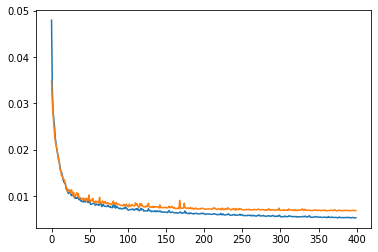

In [5]:
plt.plot(range(len(train_loss_epoch)), train_loss_epoch)
plt.plot(range(len(test_loss_epoch)), test_loss_epoch)

[0.34800734 0.7165     0.67885413]


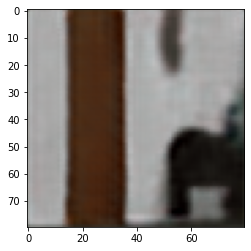

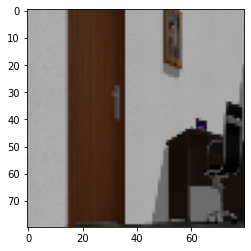

[0.81157245 0.18833333 0.03150871]


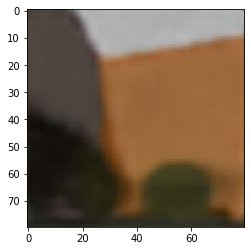

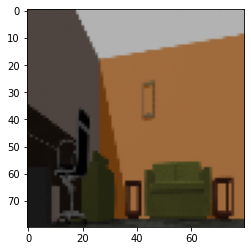

[0.25846256 0.787      0.5294283 ]


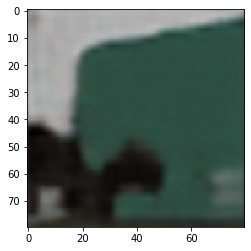

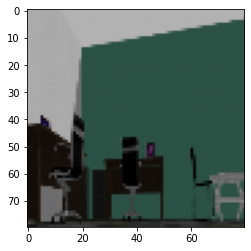

[0.74520594 0.16816667 0.62017474]


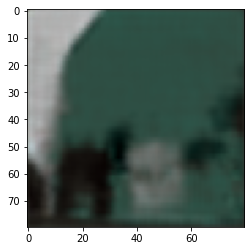

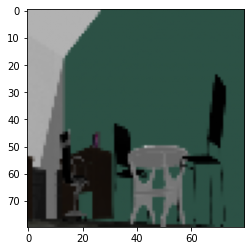

[0.39169585 0.68216667 0.90325445]


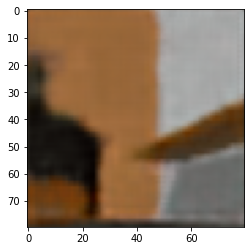

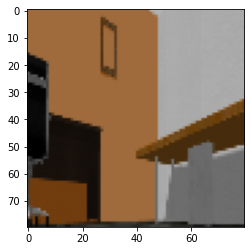

[0.87593797 0.5525     0.84239275]


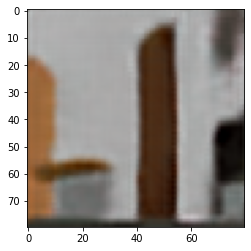

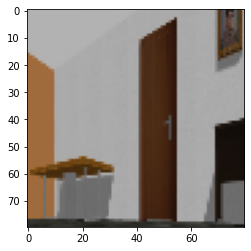

[0.48657662 0.84833333 0.79063247]


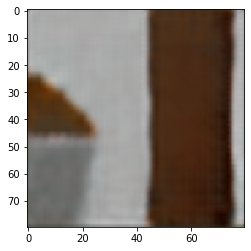

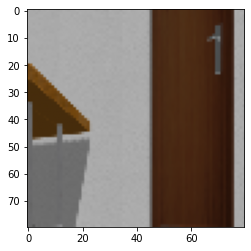

[0.10438553 0.038      0.05144849]


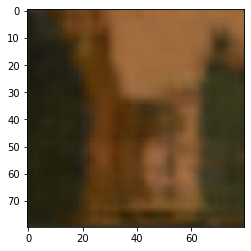

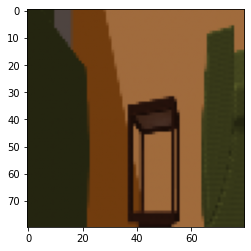

[0.83224946 0.97566667 0.85513563]


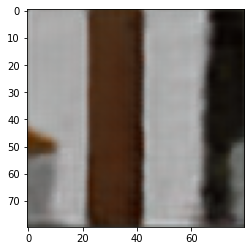

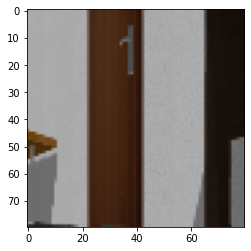

[0.11522428 0.98316667 0.1029836 ]


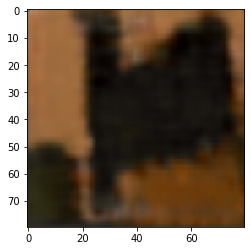

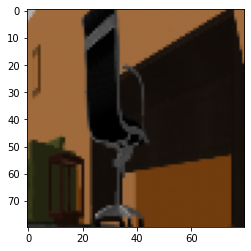

In [6]:
for i in random.sample(range(len(test_pose)), 10):
    print(test_pose[i])
    plt.imshow(net(torch.tensor(test_pose[i]).unsqueeze(0).unsqueeze(1).float().cuda()).cpu().detach().numpy().squeeze().transpose(1,2,0))
    plt.show()
    plt.imshow(test_img[i].transpose(1,2,0))
    plt.show()